<a href="https://colab.research.google.com/github/sesidhar-7/final_proj/blob/main/efficientnetb7_h5file.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Path to dataset files: /root/.cache/kagglehub/datasets/sabari50312/fundus-pytorch/versions/1
Found 8621 images belonging to 2 classes.
Found 5747 images belonging to 2 classes.
Found 2874 images belonging to 2 classes.


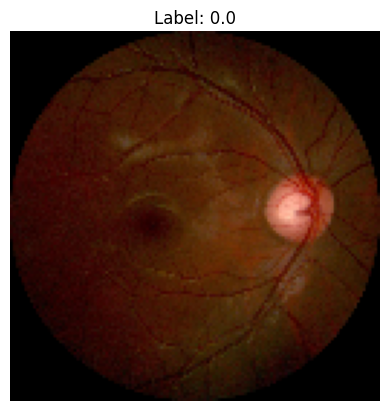

Model: "sequential_55"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb7 (Functional  (None, 4, 4, 2560)        64097687  
 )                                                               
                                                                 
 mb_conv_block_1 (MBConvBlo  (None, 4, 4, 16)          85584     
 ck)                                                             
                                                                 
 mb_conv_block_2 (MBConvBlo  (None, 4, 4, 24)          62304     
 ck)                                                             
                                                                 
 mb_conv_block_3 (MBConvBlo  (None, 4, 4, 40)          177808    
 ck)                                                             
                                                                 
 mb_conv_block_4 (MBConvBlo  (None, 4, 4, 80)        

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model saved as efficientnet_model.h5


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

180/180 [==============================] - 467s 3s/step - loss: 0.6801 - accuracy: 0.6103 - precision: 0.0000e+00 - recall: 0.0000e+00 - F1: 0.0000e+00


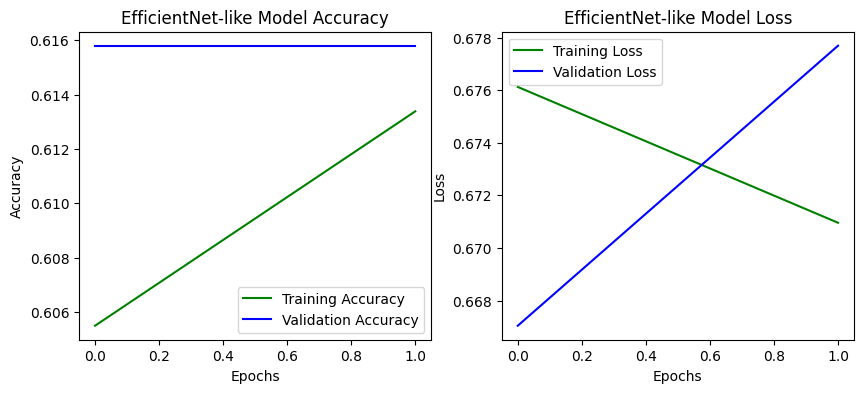

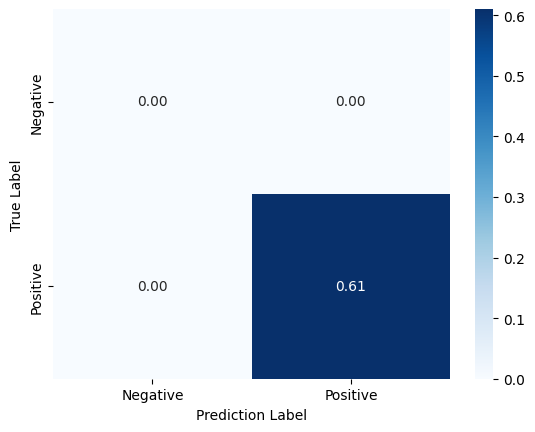

In [3]:
# Colab Cell 1: Install Dependencies
!pip install tensorflow-addons kagglehub efficientnet

# Colab Cell 2: Import Libraries
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.applications import EfficientNetB7
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import kagglehub

# Colab Cell 3: Download Dataset
TARGET_SIZE = (128, 128)
BATCH_SIZE = 16
ROOT_DIRECTORY = kagglehub.dataset_download("sabari50312/fundus-pytorch")
print("Path to dataset files:", ROOT_DIRECTORY)

# Colab Cell 4: Load Dataset
def read_dataset(path):
    datagen = ImageDataGenerator(rescale=1./255)
    train_dataset = datagen.flow_from_directory(os.path.join(path, "train"),
                                                target_size=TARGET_SIZE,
                                                batch_size=BATCH_SIZE,
                                                class_mode='binary')
    val_dataset = datagen.flow_from_directory(os.path.join(path, "val"),
                                              target_size=TARGET_SIZE,
                                              batch_size=BATCH_SIZE,
                                              class_mode='binary')
    test_dataset = datagen.flow_from_directory(os.path.join(path, "test"),
                                               target_size=TARGET_SIZE,
                                               batch_size=BATCH_SIZE,
                                               class_mode='binary')
    return train_dataset, val_dataset, test_dataset

train_dataset, val_dataset, test_dataset = read_dataset(ROOT_DIRECTORY)

# Colab Cell 5: Visualize Data
images, labels = next(train_dataset)
plt.imshow(images[0])
plt.title("Label: " + str(labels[0]))
plt.axis('off')
plt.show()

# Colab Cell 6: Define Custom EfficientNet-like Model
class MBConvBlock(tf.keras.layers.Layer):
    def __init__(self, in_channels, out_channels, expansion, kernel_size, repeats):
        super(MBConvBlock, self).__init__()
        self.blocks = []
        for _ in range(repeats):
            self.blocks.append(self._make_layer(in_channels, out_channels, expansion, kernel_size))
            in_channels = out_channels

    def _make_layer(self, in_channels, out_channels, expansion, kernel_size):
        hidden_dim = in_channels * expansion
        return models.Sequential([
            layers.Conv2D(hidden_dim, 1, use_bias=False),
            layers.BatchNormalization(),
            layers.ReLU(),
            layers.DepthwiseConv2D(kernel_size, padding='same', use_bias=False),
            layers.BatchNormalization(),
            layers.ReLU(),
            layers.Conv2D(out_channels, 1, use_bias=False),
            layers.BatchNormalization(),
        ])

    def call(self, inputs):
        x = inputs
        for block in self.blocks:
            x = block(x)
        return x

# Colab Cell 7: Build Model
strategy = tf.distribute.MirroredStrategy()
with strategy.scope():
    base_model = EfficientNetB7(include_top=False, weights='imagenet', input_shape=(128, 128, 3))
    base_model.trainable = True
    model = models.Sequential([
        base_model,
        MBConvBlock(32, 16, 1, 3, 4),
        MBConvBlock(16, 24, 6, 3, 7),
        MBConvBlock(24, 40, 6, 5, 7),
        MBConvBlock(40, 80, 6, 3, 10),
        MBConvBlock(80, 112, 6, 5, 10),
        MBConvBlock(112, 192, 6, 5, 13),
        MBConvBlock(192, 320, 6, 3, 4),
        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.2),
        layers.Dense(128, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(8, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])

    metrics = [
        tf.keras.metrics.BinaryAccuracy(name='accuracy'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tfa.metrics.F1Score(num_classes=2, threshold=0.5, average='micro', name='F1')
    ]

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  loss=tf.keras.losses.BinaryCrossentropy(),
                  metrics=metrics)

    model.summary()

# Colab Cell 8: Train Model
history_fit = model.fit(
    train_dataset,
    validation_data=val_dataset,
    batch_size=BATCH_SIZE,
    epochs=2,
    verbose=1,
    callbacks=[tf.keras.callbacks.ReduceLROnPlateau(factor=0.3)],
    shuffle=True
)

# Colab Cell 9: Save Model as .h file
model.save('efficientnet_model.h5')
print("Model saved as efficientnet_model.h5")

# Colab Cell 10: Download .h File
from google.colab import files
files.download('efficientnet_model.h5')

# Colab Cell 11: Evaluate Model
results = model.evaluate(test_dataset)

# Colab Cell 12: Plot Accuracy & Loss
loss_train = history_fit.history['loss']
loss_val = history_fit.history['val_loss']
accuracy_train = history_fit.history['accuracy']
accuracy_val = history_fit.history['val_accuracy']

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.title('EfficientNet-like Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(accuracy_train, 'g', label='Training Accuracy')
plt.plot(accuracy_val, 'b', label='Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.title('EfficientNet-like Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(loss_train, 'g', label='Training Loss')
plt.plot(loss_val, 'b', label='Validation Loss')
plt.legend()
plt.show()

# Colab Cell 13: Confusion Matrix
conf_matrix = [[results[2], results[4]], [results[3], results[1]]]
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='.2f', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Prediction Label')
plt.ylabel('True Label')
plt.show()
